#### COVID-19 Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopy
import math

import sklearn as sk

from datetime import datetime

In [2]:
full_data = pd.read_csv("../data/full_data_mar_18.csv")
full_data = full_data.fillna(0)
sl_data = pd.read_csv("../data/COVID-19_SL_Latest.csv", skiprows=1,
                      names=["date","new_cases","total_cases","new_deaths","total_deaths"])
sl_data.head()

,date,new_cases,total_cases,new_deaths,total_deaths
0,27-01-2020,1,1,0,0
1,28-01-2020,0,1,0,0
2,29-01-2020,0,1,0,0
3,30-01-2020,0,1,0,0
4,31-01-2020,0,1,0,0


#### Filter Data for Sri Lanka

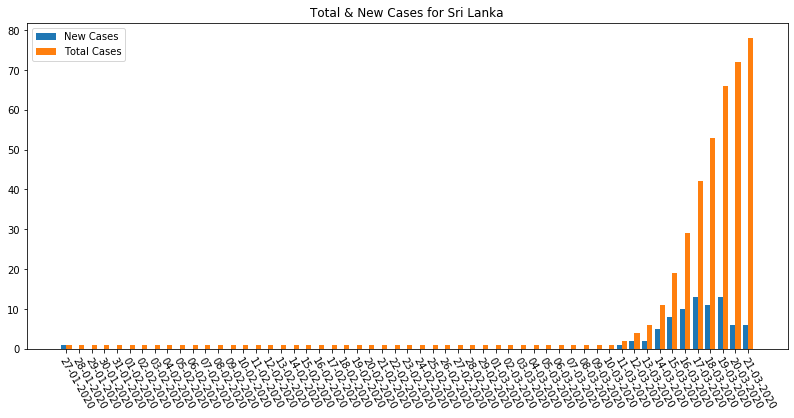

In [3]:
sl_data = sl_data[sl_data['total_cases'] > 0]
f = plt.figure(figsize=(30,6))
ax = f.add_subplot(121)
width = 0.4
x_ind = np.arange(len(sl_data['date']))
ax.set_xticks(x_ind + width / 2)
ax.set_xticklabels(sl_data['date'], rotation=-60, ha='left', rotation_mode='anchor')
ax.set_title("Total & New Cases for Sri Lanka")
ax.bar(x_ind, 'new_cases', width, data = sl_data, label = "New Cases")
ax.bar(x_ind + width, 'total_cases', width, data = sl_data, label = "Total Cases")
ax.legend()
plt.show()

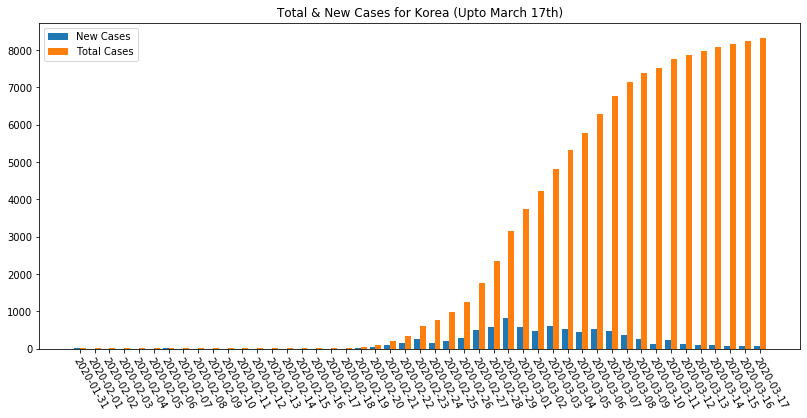

In [4]:
korea_data = full_data[(full_data['location'] == "South Korea") & (full_data['total_cases'] > 10)]
f = plt.figure(figsize=(30,6))
ax = f.add_subplot(121)
width = 0.4
x_ind = np.arange(len(korea_data['date']))
ax.set_xticks(x_ind + width / 2)
ax.set_xticklabels(korea_data['date'], rotation=-60, ha='left', rotation_mode='anchor')
ax.set_title("Total & New Cases for Korea (Upto March 17th)")

ax.bar(x_ind, 'new_cases', width, data = korea_data, label = "New Cases")
ax.bar(x_ind + width, 'total_cases', width, data = korea_data, label = "Total Cases")
ax.legend()
plt.show()

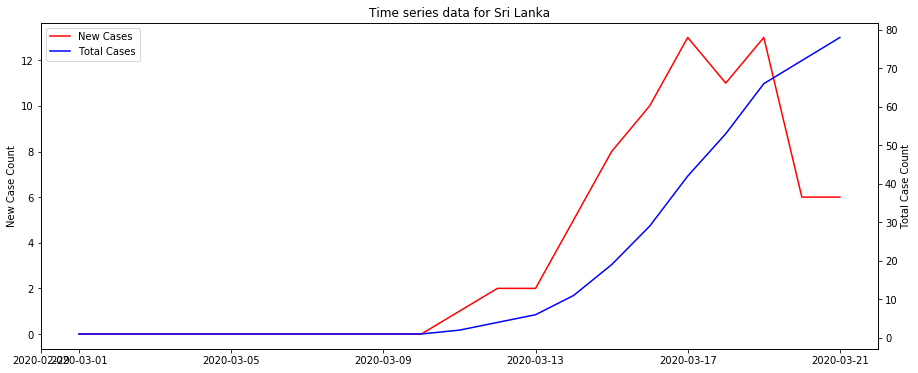

In [5]:
ts_sl_data = sl_data.copy()
ts_sl_data['date'] = pd.to_datetime(ts_sl_data['date'], dayfirst=True)
ts_sl_data.set_index('date', inplace=True)
ts_sl_data = ts_sl_data.loc['2020-03-01':'2020-03-21'].asfreq('D')

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

ln1 = ax1.plot(ts_sl_data['new_cases'], color = 'r', label = "New Cases")
ln2 = ax2.plot(ts_sl_data['total_cases'], color = 'b', label = "Total Cases")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

ax1.set_ylabel("New Case Count")
ax2.set_ylabel("Total Case Count")
plt.title("Time series data for Sri Lanka")
plt.show()

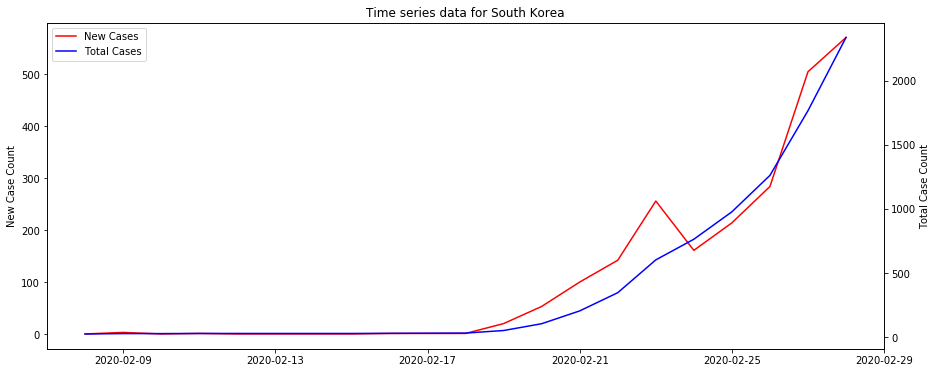

In [6]:
interim_korea_data = korea_data.copy()
interim_korea_data['new_cases'] = interim_korea_data['new_cases'].astype(int)
interim_korea_data['date'] = pd.to_datetime(interim_korea_data['date'])
interim_korea_data.set_index('date', inplace=True)
ts_korea_data = interim_korea_data.loc['2020-02-08':'2020-02-28'].asfreq('D')

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

ln1 = ax1.plot(ts_korea_data['new_cases'], color = 'r', label = "New Cases")
ln2 = ax2.plot(ts_korea_data['total_cases'], color = 'b', label = "Total Cases")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

ax1.set_ylabel("New Case Count")
ax2.set_ylabel("Total Case Count")
plt.title("Time series data for South Korea")
plt.show()

In [7]:
import itertools
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

def check_ts_stationarity(ts_data, w_size):
    rolmean = ts_data.rolling(w_size).mean()
    rolstd = ts_data.rolling(w_size).std()
    plt.figure(figsize=(15,6))
    plt.plot(ts_data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation (New Cases)')
    plt.show()
    
    decomposition = sm.tsa.seasonal_decompose(ts_data, model='additive')
    fig = decomposition.plot()
    fig.set_size_inches(12,15)
    axes = fig.get_axes()
    for ax in axes:
        ax.set_xticks(ts_data.index)
        ax.set_xticklabels(ts_data.index.date, rotation=-60, rotation_mode='anchor', ha='left')
    fig.tight_layout(pad=2.0)
    plt.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts_data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

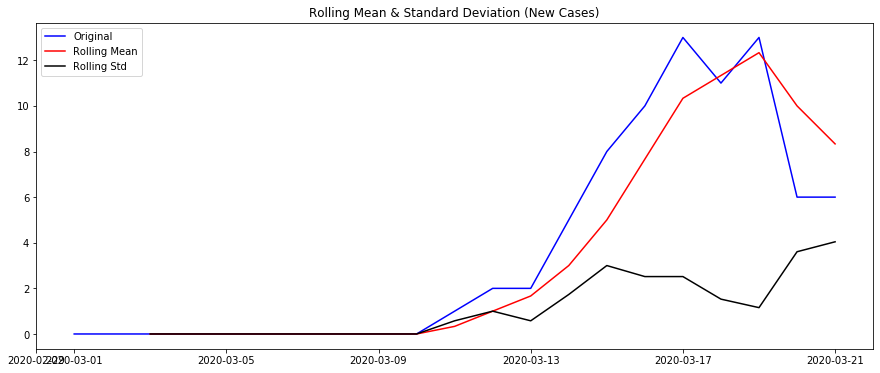

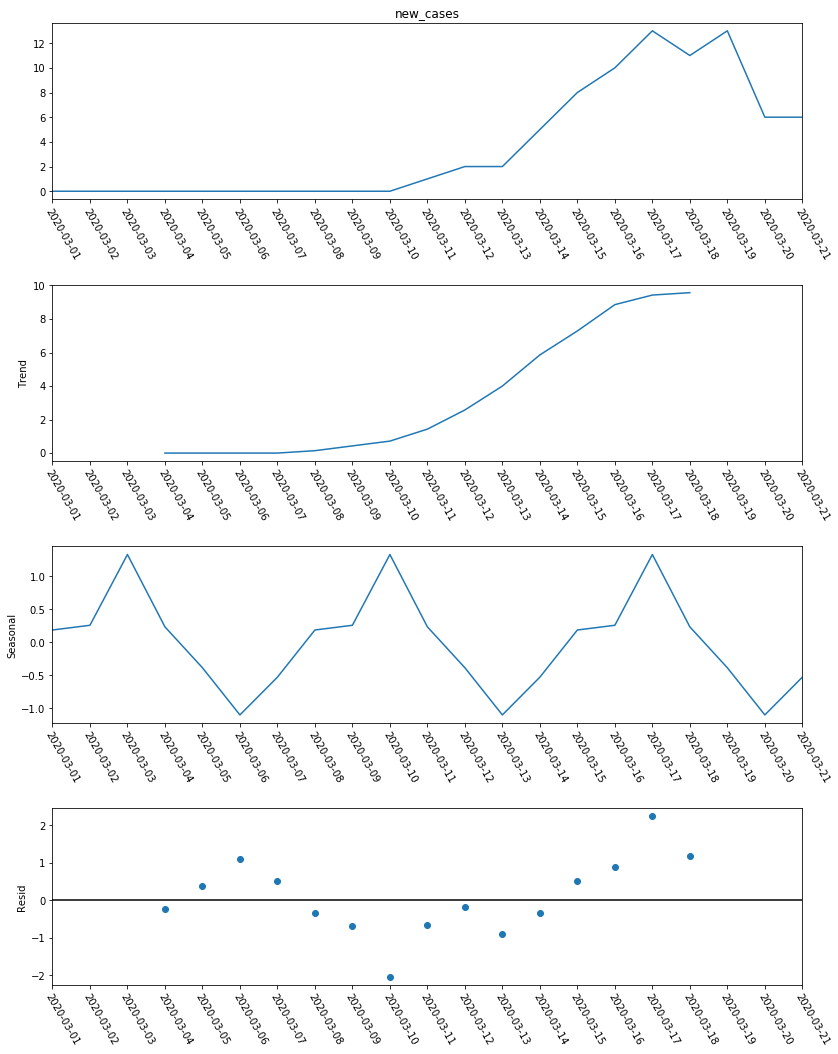

Results of Dickey-Fuller Test:
Test Statistic                  4.281036
p-value                         1.000000
#Lags Used                      8.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


In [8]:
ts_sl = ts_sl_data['new_cases']
ts_korea = ts_korea_data['new_cases']
check_ts_stationarity(ts_sl, 3)

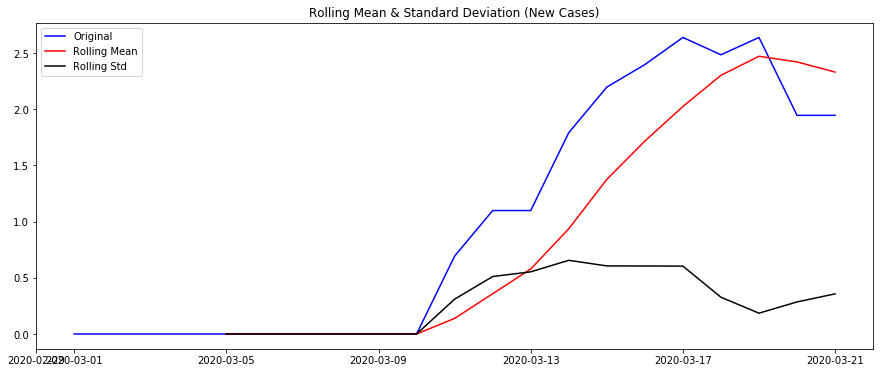

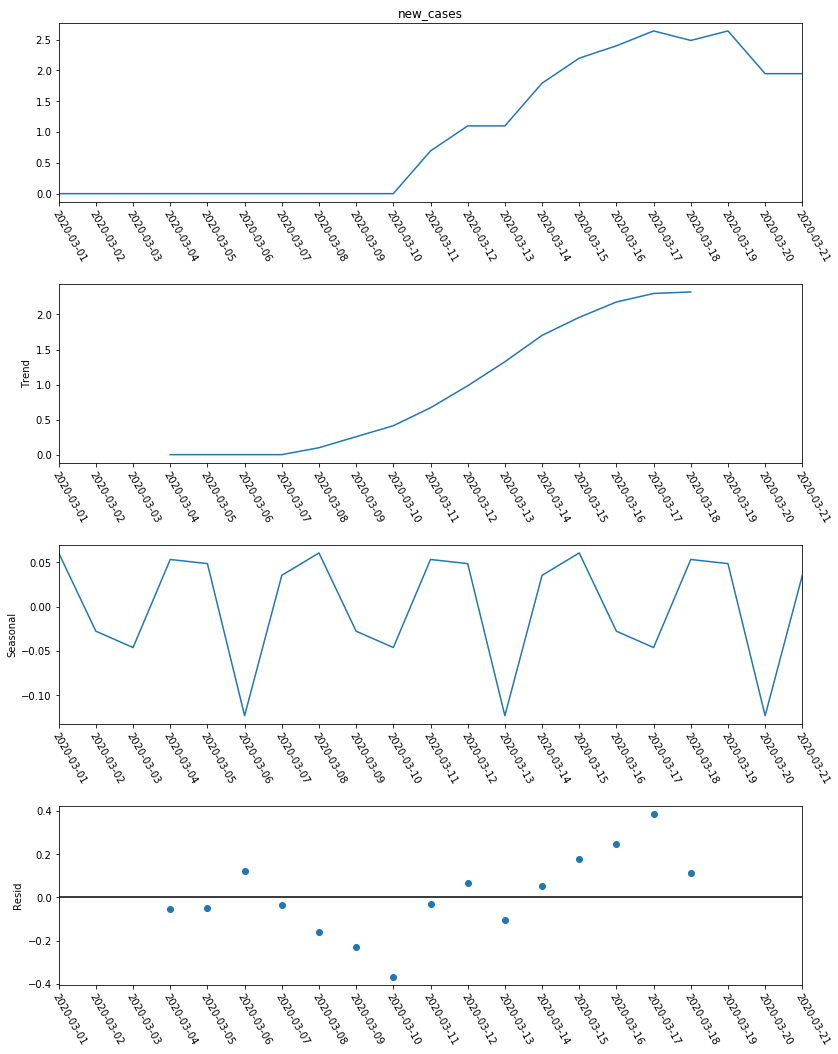

Results of Dickey-Fuller Test:
Test Statistic                 -0.626839
p-value                         0.864801
#Lags Used                      0.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


In [9]:
ts_sl_log = np.log(ts_sl + 1)
ts_korea_log = np.log(ts_korea + 1)
check_ts_stationarity(ts_sl_log, 5)

In [116]:
num_index = np.arange(len(ts_sl_log))
exog_oos_korea = interim_korea_data['new_cases'].loc['2020-02-29':'2020-03-05'].asfreq('D')
exog_oos_korea_log = np.log(exog_oos_korea + 1)
ts_sl_log_numeric = ts_sl_log.copy()
ts_sl_log_numeric.index = num_index
ts_korea_log_numeric = ts_korea_log.copy()
ts_korea_log_numeric.index = num_index
exog_oos_korea

date
2020-02-29    813
2020-03-01    586
2020-03-02    476
2020-03-03    600
2020-03-04    516
2020-03-05    438
Freq: D, Name: new_cases, dtype: int64

In [117]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

sel = ar_select_order(ts_sl_log_numeric, 7, glob=True, exog=ts_korea_log_numeric)
sel.ar_lags
res_ar = sel.model.fit()
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                             
===============================================================================
Dep. Variable:               new_cases   No. Observations:                   21
Model:             Restr. AutoReg-X(6)   Log Likelihood                   1.833
Method:                Conditional MLE   S.D. of innovations              0.214
Date:                 Sun, 22 Mar 2020   AIC                             -2.416
Time:                         16:23:37   BIC                             -2.180
Sample:                              6   HQIC                            -2.418
                                    21                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0494      0.106      0.465      0.642      -0.159       0.257
new_cases.L3     0.8365      0.176      4.747      0.000       0.491       1.182
new_cases.L6    -0.9178      0.179     -5.133      0.000      -1.268      -0.567
new_cases        0.2732      0.048      5.743      0.000       0.180       0.366
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7925           -0.6333j            1.0144           -0.3927
AR.2           -0.7925           +0.6333j            1.0144            0.3927
AR.3           -0.1522           -1.0029j            1.0144           -0.2740
AR.4           -0.1522           +1.0029j            1.0144            0.2740
AR.5            0.9446           -0.3697j            1.0144           -0.0594
AR.6            0.9446           +0.3697j            1.0144            0.0594
-----------------------------------------------------------------------------
"""

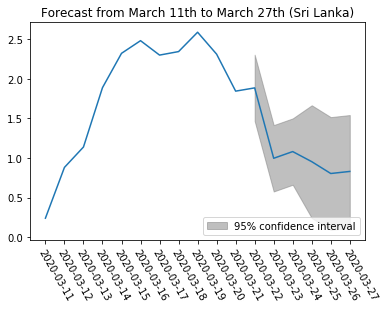

In [119]:
fig = res_ar.plot_predict(10, 26, exog_oos=exog_oos_korea_log)
pred_date_range = pd.date_range('2020-03-11','2020-03-27', freq='1D').date
ax = fig.get_axes()
ax[0].set_xticks(np.arange(10,27))
ax[0].set_xticklabels(pred_date_range, rotation=-60, rotation_mode='anchor', ha='left')
plt.title("Forecast from March 11th to March 27th (Sri Lanka)")
plt.show()

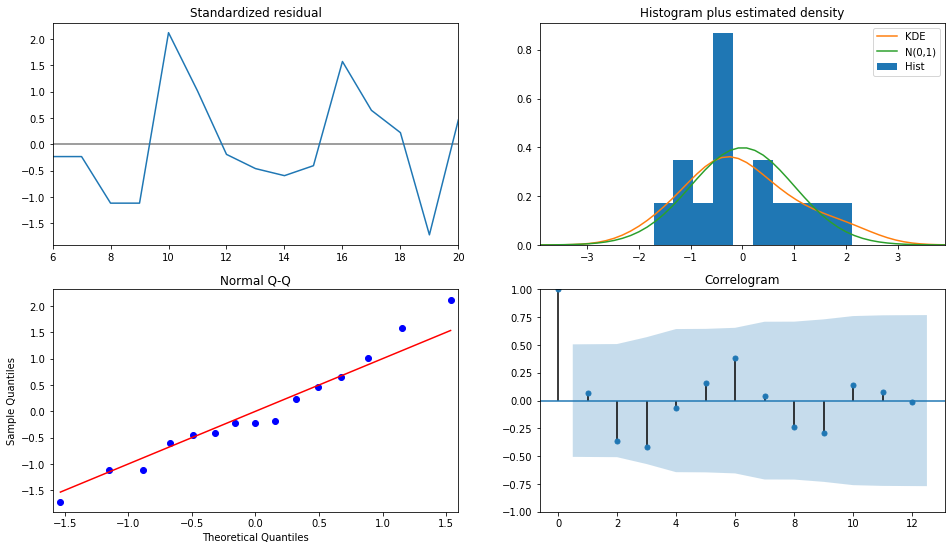

In [121]:
fig = plt.figure(figsize=(16,9))
fig = res_ar.plot_diagnostics(fig=fig, lags=12)

In [122]:
fcast_ar = round(np.exp(res_ar.predict(start=10, end=26, exog_oos=exog_oos_korea)) - 1).astype(int)
fcast_ar.index = pred_date_range
fcast_ar

2020-03-11                      0
2020-03-12                      1
2020-03-13                      2
2020-03-14                      6
2020-03-15                      9
2020-03-16                     11
2020-03-17                      9
2020-03-18                      9
2020-03-19                     12
2020-03-20                      9
2020-03-21                      5
2020-03-22   -9223372036854775808
2020-03-23   -9223372036854775808
2020-03-24   -9223372036854775808
2020-03-25   -9223372036854775808
2020-03-26   -9223372036854775808
2020-03-27   -9223372036854775808
dtype: int64

In [123]:
prediction_ts = ts_sl_log_numeric
exog_ts = ts_korea_log_numeric

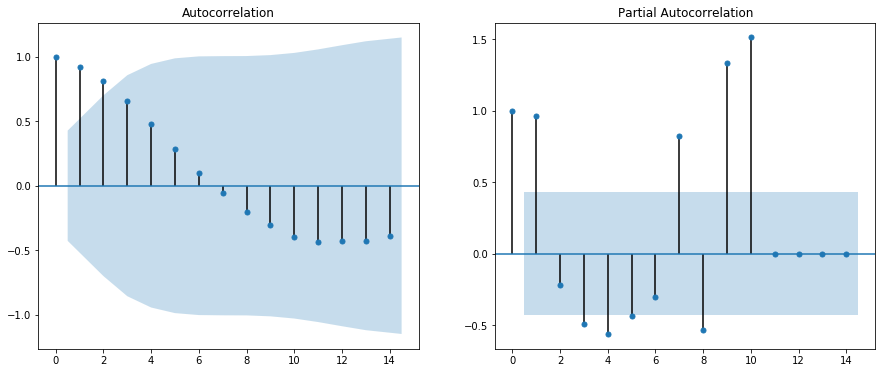

In [124]:
import statsmodels.api as sm

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(prediction_ts, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(prediction_ts, ax=ax2, method='ols')
plt.show()

In [140]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(prediction_ts, order=(1,0,3))
res_ARIMA = model.fit(trend='nc')
res_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              new_cases   No. Observations:                   21
Model:                     ARMA(1, 3)   Log Likelihood                  -3.425
Method:                       css-mle   S.D. of innovations              0.258
Date:                Sun, 22 Mar 2020   AIC                             16.851
Time:                        17:40:19   BIC                             22.073
Sample:                             0   HQIC                            17.984
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.new_cases     0.9395      0.057     16.411      0.000       0.827       1.052
ma.L1.new_cases     0.0963      0.245      0.394      0.694      -0.383       0.576
ma.L2.new_cases     0.2657      0.260      1.020      0.308      -0.245       0.776
ma.L3.new_cases     0.4754      0.243      1.955      0.051      -0.001       0.952
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0644           +0.0000j            1.0644            0.0000
MA.1            0.4389           -1.1275j            1.2100           -0.1909
MA.2            0.4389           +1.1275j            1.2100            0.1909
MA.3           -1.4368           -0.0000j            1.4368           -0.5000
-----------------------------------------------------------------------------
"""

In [141]:
fitted_date_range = pd.date_range('2020-03-01','2020-03-21', freq='1D').date
fcast_date_range = pd.date_range('2020-03-22','2020-03-27', freq='1D').date
predicted_date_range = pd.date_range('2020-03-01','2020-03-27', freq='1D').date

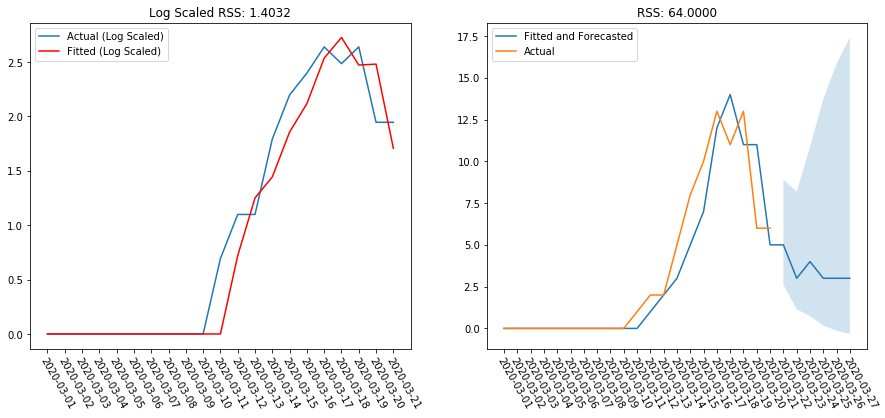

In [144]:
fitted_values = res_ARIMA.fittedvalues.copy()
fitted_values.index = fitted_date_range
fitted_scaled = np.exp(fitted_values) - 1
fitted_scaled.index = fitted_date_range
plot_prediction_ts = prediction_ts.copy()
plot_prediction_ts.index = fitted_date_range

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(plot_prediction_ts, label="Actual (Log Scaled)")
ax1.plot(fitted_values, color='red', label="Fitted (Log Scaled)")
ax1.set_xticks(fitted_date_range)
ax1.set_xticklabels(fitted_date_range, rotation=-60, rotation_mode='anchor', ha='left')
ax1.set_title("Log Scaled RSS: %.4f" % sum(((fitted_values - plot_prediction_ts)**2).dropna()))
ax1.legend()

predicted_scaled = round(np.exp(res_ARIMA.predict(0,26)) - 1).astype(int)
predicted_scaled.index = predicted_date_range

fitted_scaled = round(np.exp(fitted_values) - 1).astype(int)
fitted_scaled.index = fitted_date_range

fcast = res_ARIMA.forecast(6)
conf_int = fcast[2]
conf_int_lower_scaled = np.exp(conf_int[:,0]) - 1
conf_int_upper_scaled = np.exp(conf_int[:,1]) - 1

fcast_scaled = round(pd.Series(np.exp(fcast[0])) - 1).astype(int)
fcast_scaled.index = fcast_date_range

ax2 = fig.add_subplot(122)
ax2.plot(predicted_scaled, label="Fitted and Forecasted")
ax2.plot(ts_sl, label="Actual")
ax2.fill_between(fcast_date_range, conf_int_lower_scaled, conf_int_upper_scaled, alpha=0.2)
ax2.legend(loc=2)
ax2.set_xticks(predicted_date_range)
ax2.set_xticklabels(predicted_date_range, rotation=-60, rotation_mode='anchor', ha='left')
plt.title("RSS: %.4f" % sum(((fitted_scaled - ts_sl)**2).dropna()))

plt.show()

In [143]:
print(fcast_scaled)

2020-03-22    5
2020-03-23    3
2020-03-24    4
2020-03-25    3
2020-03-26    3
2020-03-27    3
dtype: int64


In [145]:
from statsmodels.tsa.arima_model import ARIMA

model_exog = ARIMA(prediction_ts, order=(1,0,3), exog=exog_ts)
res_ARIMA_exog = model_exog.fit(trend='nc', disp=-1)
res_ARIMA_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              new_cases   No. Observations:                   21
Model:                     ARMA(1, 3)   Log Likelihood                  -4.619
Method:                       css-mle   S.D. of innovations              0.290
Date:                Sun, 22 Mar 2020   AIC                             21.238
Time:                        19:52:08   BIC                             27.505
Sample:                             0   HQIC                            22.598
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
new_cases           0.3907      0.015     26.641      0.000       0.362       0.419
ar.L1.new_cases     0.6478      0.300      2.156      0.031       0.059       1.237
ma.L1.new_cases    -0.4734      0.331     -1.429      0.153      -1.123       0.176
ma.L2.new_cases    -0.3270      0.302     -1.082      0.279      -0.919       0.265
ma.L3.new_cases    -0.1995      0.307     -0.651      0.515      -0.800       0.401
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5438           +0.0000j            1.5438            0.0000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -1.3194           -1.8084j            2.2386           -0.3503
MA.3           -1.3194           +1.8084j            2.2386            0.3503
-----------------------------------------------------------------------------
"""

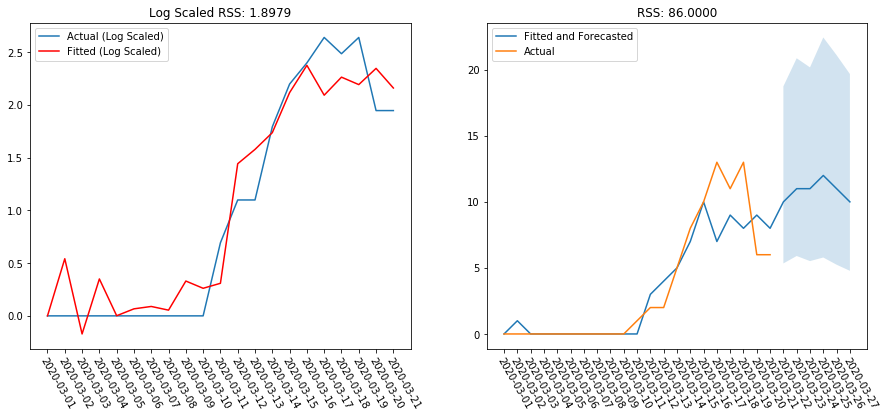

In [146]:
fitted_values = res_ARIMA_exog.fittedvalues.copy()
fitted_values.index = fitted_date_range
fitted_scaled = np.exp(fitted_values) - 1
fitted_scaled.index = fitted_date_range
plot_prediction_ts = prediction_ts.copy()
plot_prediction_ts.index = fitted_date_range

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(plot_prediction_ts, label="Actual (Log Scaled)")
ax1.plot(fitted_values, color='red', label="Fitted (Log Scaled)")
ax1.set_xticks(fitted_date_range)
ax1.set_xticklabels(fitted_date_range, rotation=-60, rotation_mode='anchor', ha='left')
ax1.set_title("Log Scaled RSS: %.4f" % sum(((fitted_values - plot_prediction_ts)**2).dropna()))
ax1.legend()

predicted_scaled = round(np.exp(res_ARIMA_exog.predict(0,26, exog=exog_oos_korea_log)) - 1).astype(int)
predicted_scaled.index = predicted_date_range

fitted_scaled = round(np.exp(fitted_values) - 1).astype(int)
fitted_scaled.index = fitted_date_range

fcast = res_ARIMA_exog.forecast(6, exog=exog_oos_korea_log)
conf_int = fcast[2]
conf_int_lower_scaled = np.exp(conf_int[:,0]) - 1
conf_int_upper_scaled = np.exp(conf_int[:,1]) - 1

fcast_scaled = round(pd.Series(np.exp(fcast[0])) - 1).astype(int)
fcast_scaled.index = fcast_date_range

ax2 = fig.add_subplot(122)
ax2.plot(predicted_scaled, label="Fitted and Forecasted")
ax2.plot(ts_sl, label="Actual")
ax2.fill_between(fcast_date_range, conf_int_lower_scaled, conf_int_upper_scaled, alpha=0.2)
ax2.legend(loc=2)
ax2.set_xticks(predicted_date_range)
ax2.set_xticklabels(predicted_date_range, rotation=-60, rotation_mode='anchor', ha='left')
plt.title("RSS: %.4f" % sum(((fitted_scaled - ts_sl)**2).dropna()))

plt.show()

In [135]:
print(fcast_scaled)

2020-03-22    10
2020-03-23    11
2020-03-24    11
2020-03-25    12
2020-03-26    11
2020-03-27    10
dtype: int64
